In [ ]:
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

print("Vector for 'Hello':", model['Hello'])

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Vector for 'Hello': [-0.05102539  0.12060547 -0.01257324  0.03088379 -0.08544922  0.0534668
 -0.13964844 -0.16308594  0.08300781  0.20507812 -0.09423828  0.15527344
 -0.00418091  0.02111816 -0.10986328  0.22460938  0.22265625  0.15917969
  0.05786133 -0.15527344  0.23046875  0.34765625  0.44335938 -0.14550781
  0.15136719  0.02209473 -0.16308594  0.2578125   0.20019531  0.06054688
 -0.0222168  -0.13183594 -0.06396484 -0.12792969  0.09814453 -0.13574219
  0.01928711  0.25195312  0.14257812  0.2421875   0.03173828 -0.17089844
  0.26171875  0.4296875   0.24804688 -0.10351562 -0.13867188 -0.14257812
 -0.20703125 -0.00860596 -0.43359375 -0.01757812  0.40234375  0.32617188
  0.33203125  0.01000977 -0.11523438 -0.12695312  0.01940918 -0.25390625
  0.00393677 -0.00344849 -0.19042969  0.05419922  0.14453125 -0.0546875
 -0.11132812  0.15136719 -0.265625    0.20019531  0.14941406  0.16601562
  0.06835938  0.006

In [ ]:
import pandas as pd

df  = pd.read_csv("/content/drive/MyDrive/ner_dataset.csv", encoding = 'unicode_escape')

In [ ]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
df.isnull().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

In [ ]:
#there are too many NAN values is Sentences column
print(len(df))

1048575


In [ ]:
#dropping NAN values isn't an option we can propogate the previous values
df['Sentence #']=df['Sentence #'].ffill()

In [ ]:
df.isnull().sum()

Sentence #     0
Word          10
POS            0
Tag            0
dtype: int64

In [ ]:
#renaming columns for ease of use
df.rename(columns={'Sentence #':'Sent','Word':'tkn','Tag':'pos_ind'},inplace=True)

In [ ]:
df = df[['Sent', 'tkn', 'pos_ind']]

In [ ]:
#case match values
df['tkn'] = df['tkn'].str.lower()

In [ ]:
df.head()

,Sent,tkn,pos_ind
0,Sentence: 1,thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [ ]:
pip install gensim

In [ ]:
#Group a DataFrame by the 'Sentence' column and create a list of lists,
#where each inner list represents a sentence and contains tuples of tokens and their respective part-of-speech tags.
sentence_groups = df.groupby('Sent')

sentence_all = []
for _, group in sentence_groups:
    sentence_tokens_pos = list(zip(group['tkn'], group['pos_ind']))
    sentence_all.append(sentence_tokens_pos)


In [ ]:
print(sentence_all[0])

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [ ]:
import tensorflow as tf

In [ ]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True


In [ ]:
import tensorflow as tf

# Set hyperparameters based on GPU availability
BATCH_SIZE = 512 if tf.test.is_gpu_available() else 32
EPOCHS = 5
MAX_LEN = 75
EMBEDDING = 40 if tf.test.is_gpu_available() else 20

In [ ]:
words = list(set(df['tkn'].values))
tags = list(set(df["pos_ind"].values))

In [ ]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx.update({"UNK": 1, "PAD": 0})

tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

In [ ]:
hits, misses = 0, 0
embedding_dim = 300

In [ ]:
import numpy as np

embedding_matrix = np.zeros((len(word2idx), embedding_dim))
#print(len(embedding_matrix))
#print(word2idx)
for word, i in zip(word2idx.keys(), word2idx.values()):
    try:
        embedding_vector = model[word]
        embedding_matrix[i] = embedding_vector
        hits += 1
    except Exception:
        misses += 1
        pass
#print(hits)

In [ ]:
pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 380.4 kB/s eta 0:00:00


In [ ]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
X = [[word2idx.get(w[0], 1) for w in s] for s in sentence_all]
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=0)

y = [[tag2idx[w[1]] for w in s] for s in sentence_all]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=0)
y = [to_categorical(i, num_classes=len(tags)+1) for i in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
!pip install tensorflow-addons

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy


def build_model(max_len=75, input_dim=len(word2idx), embedding_dim=300):
    # Model definition
    input_layer = Input(shape=(max_len,))

    # Get embeddings
    embeddings = Embedding(
        input_dim,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        mask_zero=True,
        trainable=True,
        name='embedding_layer'
    )(input_layer)

    # variational biLSTM
    output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
    output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
    # Stacking
    output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

    # Adding more non-linearity
    dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)
    mask = Input(shape=(max_len,), dtype=tf.bool)
    crf = CRF(18, name='crf')
    predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

    model = Model(input_layer, potentials)
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Use Adam optimizer with default learning rate
        loss=SigmoidFocalCrossEntropy()    )

    return model

model = build_model()

In [ ]:
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=1)

callbacks = [save_model, es]

model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 75)]              0         
                                                                 
 embedding_layer (Embedding  (None, 75, 300)           9546000   
 )                                                               
                                                                 
 bidirectional_39 (Bidirect  (None, 75, 100)           140400    
 ional)                                                          
                                                                 
 bidirectional_40 (Bidirect  (None, 75, 200)           160800    
 ional)                                                          
                                                                 
 bidirectional_41 (Bidirect  (None, 75, 100)           100400    
 ional)                                                   

In [ ]:
history = model.fit(
  X_train,
  y_train,
  batch_size=64,
  epochs=2,
  validation_data=(X_test, y_test),
  callbacks=callbacks,
  shuffle=True
)

Epoch 1/2


675/675 [==============================] - ETA: 0s - loss: 0.3284
Epoch 1: val_loss improved from inf to 0.08341, saving model to ner_crf.h5
675/675 [==============================] - 82s 83ms/step - loss: 0.3284 - val_loss: 0.0834
Epoch 2/2
675/675 [==============================] - ETA: 0s - loss: 0.0373
Epoch 2: val_loss improved from 0.08341 to 0.01768, saving model to ner_crf.h5
675/675 [==============================] - 31s 46ms/step - loss: 0.0373 - val_loss: 0.0177


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Predicting labels
y_pred = model.predict(X_test)

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=-1)
y_test_labels = np.argmax(y_test, axis=-1)

# Flatten the labels and predictions for calculating token-level metrics
y_pred_flat = y_pred_labels.flatten()
y_test_flat = y_test_labels.flatten()

# Token-level metrics
print("Token-Level Metrics:")
print("Accuracy:", accuracy_score(y_test_flat, y_pred_flat))
# print(classification_report(y_test_flat, y_pred_flat))

150/150 [==============================] - 10s 11ms/step
Token-Level Metrics:
Accuracy: 0.9825410063942174


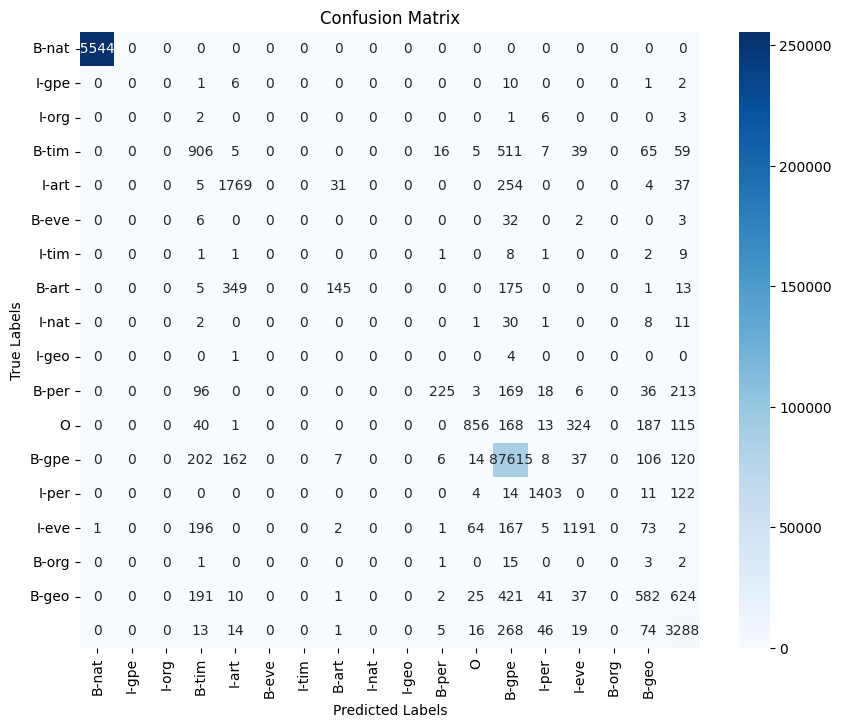

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=tags, yticklabels=tags)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()